In [1]:
# Syed Rakin Ahmed - 2023-08-22

import os, csv, json, cv2, random, time, sys, shutil
import numpy as np
import pandas as pd

import multiprocessing
from joblib import Parallel, delayed

from tqdm import tqdm
from matplotlib import pyplot as plt
from zipfile import ZipFile
from PIL import Image, ImageDraw

import torch

print(sys.version)
print(torch.__version__)

3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
1.9.0a0+2ecb2c7


In [1]:
# Syed Rakin Ahmed - 2023-08-22

## Verify that the bounding box labels are correct on the image and correspond to the actual yolov5 prediction

In [15]:
df_bb = pd.read_csv('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/predictions/20230822_detector_predictions_v2/dysis_bb_V2.csv')
df_bb

Unnamed: 0                                         image_path  \
0              0  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
1              1  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
2              2  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
3              3  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4              4  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
...          ...                                                ...   
4093        4093  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4094        4094  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4095        4095  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4096        4096  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4097        4097  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   

                 image  x1    x2   y1    y2  det_conf dataset  
0     00017_img000.bmp   2  1020    1   762  0.893247    test  
1     00017_img007.bmp  33  1021    1   654  0.931311    test  
2     00017_img014.bmp  36  1023    2   652  0.932327    test  
3     00017_img021.bmp  36  1018    2   650  0.938566    test  
4     00017_img028.bmp  27  1012    2   645  0.905220    test  
...                ...  ..   ...  ...   ...       ...     ...  
4093  05620_img084.jpg  76  1443  332  1200  0.792751    test  
4094  05620_img094.jpg  71  1442  344  1200  0.792758    test  
4095  05620_img104.jpg  59  1437  324  1199  0.770394    test  
4096  05620_img114.jpg  76  1444  368  1198  0.778058    test  
4097  05620_img124.jpg  78  1432  336  1199  0.759254    test  

[4098 rows x 9 columns]

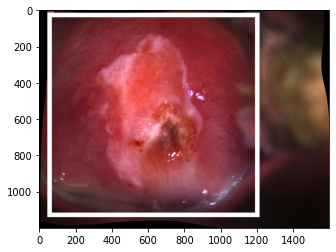

In [16]:
def plot_bounding_box(img, img_name, df_bb):
    #
    plotted_image = ImageDraw.Draw(img)
    x0 = df_bb.loc[df_bb['image']==img_name, 'x1'].values.item()
    y0 = df_bb.loc[df_bb['image']==img_name, 'y1'].values.item()
    x1 = df_bb.loc[df_bb['image']==img_name, 'x2'].values.item()
    y1 = df_bb.loc[df_bb['image']==img_name, 'y2'].values.item()
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline='white', width=25)
    plotted_image.text((x0, y0 - 10), 'cervix')
    #
    plt.imshow(np.array(img))
    plt.show()

img_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/data/dysis/compiled/'
image_files = next(os.walk(img_dir))[2]
image_file = random.choice(image_files)

img = Image.open(os.path.join(img_dir,image_file))

#Plot the Bounding Box
plot_bounding_box(img, image_file, df_bb)

In [17]:
image_file

'01878_img114.jpg'

## Find the 50 or so images with the lowest/highest cervix detection scores

In [18]:
img_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/predictions/20230822_detector_predictions_v2/images/'
image_files = list(df_bb.sort_values(by=['det_conf'])[:50]['image'].values)
image_paths = [os.path.join(img_dir, image_file) for image_file in image_files]
images = [plt.imread(image_paths[i]) for i in range(len(image_paths))]

In [19]:
df_bb.sort_values(by=['det_conf'])[:50]['det_conf'].values

array([0.00813557, 0.0240935 , 0.0748626 , 0.108317  , 0.112345  ,
       0.150777  , 0.152466  , 0.162697  , 0.169511  , 0.17294   ,
       0.17649   , 0.240625  , 0.281274  , 0.305839  , 0.313523  ,
       0.32336   , 0.325639  , 0.332335  , 0.346159  , 0.353051  ,
       0.370983  , 0.383699  , 0.390895  , 0.39229   , 0.39902   ,
       0.412965  , 0.449757  , 0.454652  , 0.456017  , 0.457769  ,
       0.468669  , 0.477591  , 0.485713  , 0.492689  , 0.513764  ,
       0.515855  , 0.517523  , 0.522659  , 0.52308   , 0.525941  ,
       0.526645  , 0.539266  , 0.54358   , 0.54428   , 0.544719  ,
       0.551571  , 0.556052  , 0.560556  , 0.565255  , 0.565702  ])

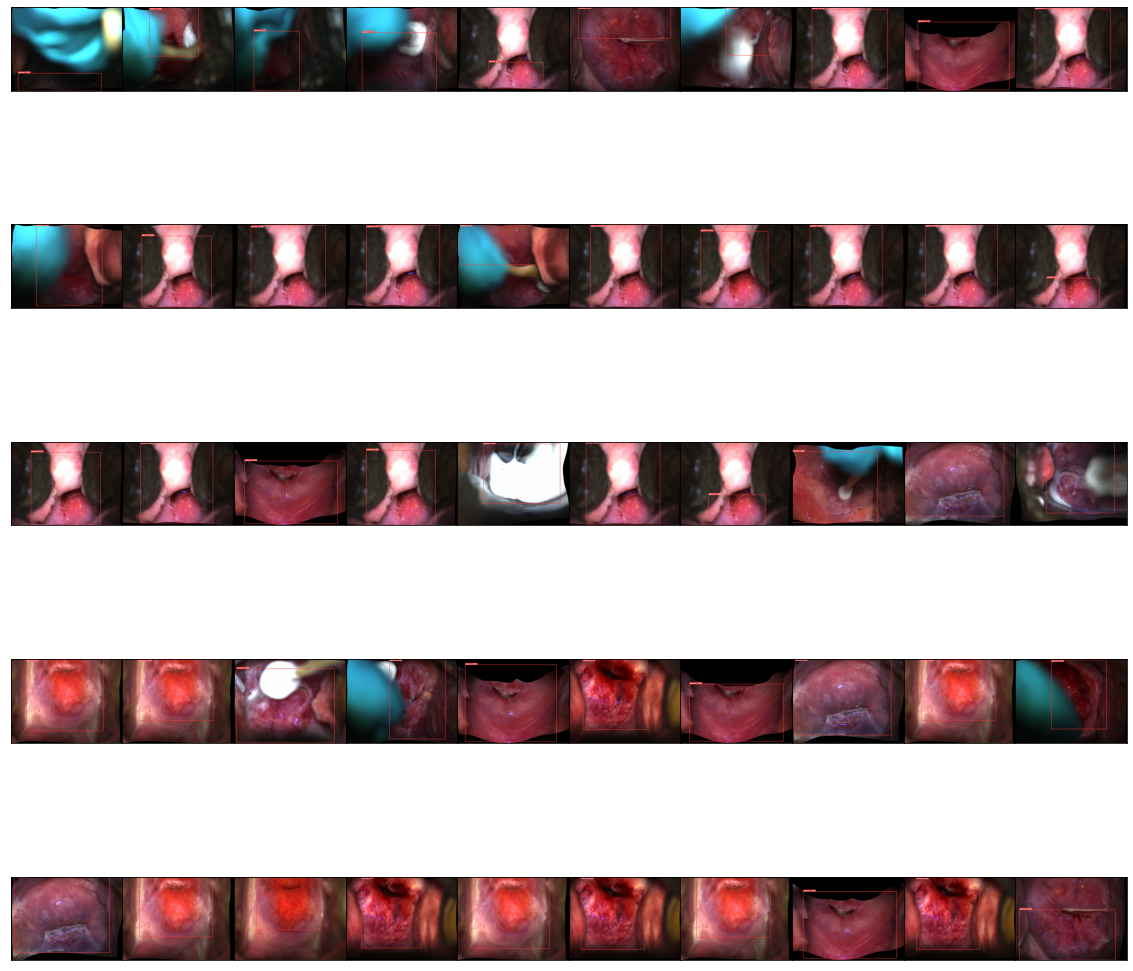

In [20]:
# matplotlib display
fig = plt.subplots(5,10,figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for j in range(len(images)):
# for j in range(images.shape[0]):
    plt.subplot(5,10,j+1)
    subfig = plt.imshow(images[j])
#     subfig = plt.imshow(images[j,:,:,:])
    subfig.axes.get_xaxis().set_visible(False)
    subfig.axes.get_yaxis().set_visible(False)

In [21]:
image_files

['04462_img014.jpg',
 '04580_img070.jpg',
 '04580_img077.jpg',
 '04957_img042.jpg',
 '03102_img124.jpg',
 '04081_img014.jpg',
 '05392_img094.jpg',
 '03102_img114.jpg',
 '04742_img124.jpg',
 '03102_img070.jpg',
 '04462_img056.jpg',
 '03102_img042.jpg',
 '03102_img104.jpg',
 '03102_img084.jpg',
 '04462_img049.jpg',
 '03102_img049.jpg',
 '03102_img007.jpg',
 '03102_img063.jpg',
 '03102_img094.jpg',
 '03102_img014.jpg',
 '03102_img028.jpg',
 '03102_img077.jpg',
 '04742_img104.jpg',
 '03102_img035.jpg',
 '04354_img035.jpg',
 '03102_img056.jpg',
 '03102_img021.jpg',
 '04755_img042.jpg',
 '04783_img077.jpg',
 '04289_img124.jpg',
 '01236_img077.jpg',
 '01236_img084.jpg',
 '03662_img021.jpg',
 '05043_img070.jpg',
 '04742_img084.jpg',
 '00407_img000.jpg',
 '04742_img114.jpg',
 '04783_img114.jpg',
 '01236_img094.jpg',
 '05294_img035.jpg',
 '04783_img124.jpg',
 '01236_img104.jpg',
 '01236_img000.jpg',
 '00407_img021.jpg',
 '01236_img070.jpg',
 '00407_img007.jpg',
 '01236_img124.jpg',
 '04742_img09

In [22]:
image_files_all = []
image_files_all.extend(image_files)

In [23]:
image_files = list(df_bb.sort_values(by=['det_conf'])[-50:]['image'].values)
image_paths = [os.path.join(img_dir, image_file) for image_file in image_files]
images = [plt.imread(image_paths[i]) for i in range(len(image_paths))]

In [24]:
df_bb.sort_values(by=['det_conf'])[-50:]['det_conf'].values

array([0.97472 , 0.974771, 0.974883, 0.974921, 0.974935, 0.974958,
       0.974984, 0.975026, 0.975141, 0.975216, 0.975231, 0.975384,
       0.975477, 0.975502, 0.975515, 0.975544, 0.975583, 0.97563 ,
       0.975634, 0.975658, 0.975673, 0.975809, 0.975952, 0.976108,
       0.976138, 0.976163, 0.976199, 0.976393, 0.976448, 0.976478,
       0.97653 , 0.976636, 0.976659, 0.976782, 0.976832, 0.977055,
       0.977086, 0.977202, 0.977226, 0.977458, 0.977562, 0.977985,
       0.977994, 0.978255, 0.978836, 0.978873, 0.979762, 0.980311,
       0.9806  , 0.982506])

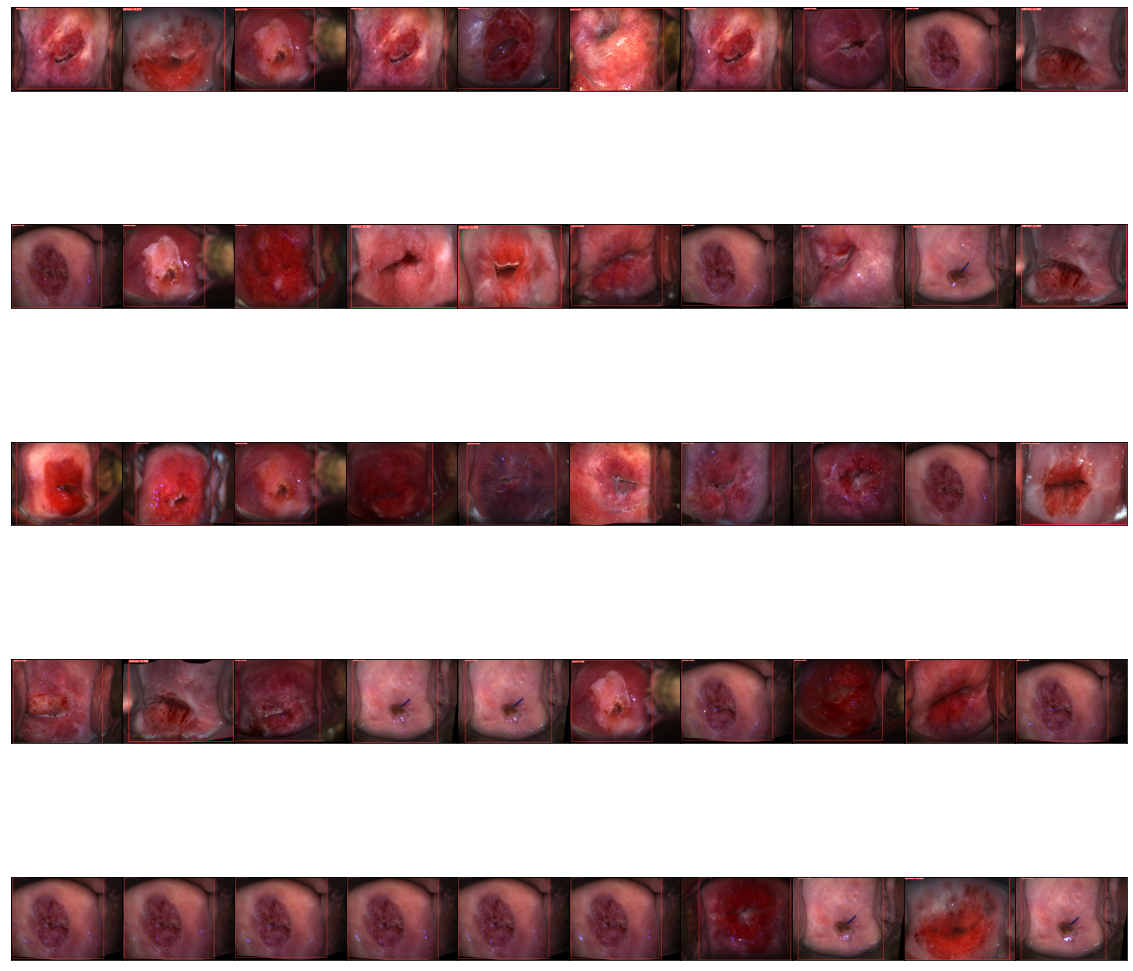

In [25]:
# matplotlib display
fig = plt.subplots(5,10,figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for j in range(len(images)):
# for j in range(images.shape[0]):
    plt.subplot(5,10,j+1)
    subfig = plt.imshow(images[j])
#     subfig = plt.imshow(images[j,:,:,:])
    subfig.axes.get_xaxis().set_visible(False)
    subfig.axes.get_yaxis().set_visible(False)

In [26]:
image_files

['02755_img035.jpg',
 '00063_img007.bmp',
 '01878_img014.jpg',
 '02755_img028.jpg',
 '04004_img056.jpg',
 '01994_img021.jpg',
 '02755_img014.jpg',
 '03977_img014.jpg',
 '03739_img124.jpg',
 '00068_img007.bmp',
 '03739_img014.jpg',
 '01878_img042.jpg',
 '04686_img000.jpg',
 '00053_img014.bmp',
 '00162_img077.bmp',
 '05039_img007.jpg',
 '03739_img114.jpg',
 '04623_img063.jpg',
 '04067_img014.jpg',
 '00068_img021.bmp',
 '03567_img000.jpg',
 '02406_img007.jpg',
 '01878_img007.jpg',
 '04703_img000.jpg',
 '04315_img028.jpg',
 '04755_img007.jpg',
 '03958_img014.jpg',
 '04951_img007.jpg',
 '03739_img021.jpg',
 '00129_img000.bmp',
 '05602_img007.jpg',
 '00068_img028.bmp',
 '04703_img007.jpg',
 '04067_img124.jpg',
 '04067_img114.jpg',
 '01878_img021.jpg',
 '03739_img084.jpg',
 '03557_img000.jpg',
 '05039_img000.jpg',
 '03739_img070.jpg',
 '03739_img063.jpg',
 '03739_img035.jpg',
 '03739_img077.jpg',
 '03739_img049.jpg',
 '03739_img056.jpg',
 '03739_img042.jpg',
 '04951_img000.jpg',
 '04067_img09

In [27]:
image_files_all.extend(image_files)

## Draw bb on top 50 and bottom 50 images

In [28]:
def save_bb_image(img_name, img_src_dir, img_str_dir, df_bb):
    #
    img = plt.imread(os.path.join(img_src_dir, img_name))
    #
    x0 = int(df_bb.loc[df_bb['image']==img_name, 'x1'].values.item())
    y0 = int(df_bb.loc[df_bb['image']==img_name, 'y1'].values.item())
    x1 = int(df_bb.loc[df_bb['image']==img_name, 'x2'].values.item())
    y1 = int(df_bb.loc[df_bb['image']==img_name, 'y2'].values.item())
    #
    result_bb = cv2.rectangle(img, (x0,y0), (x1,y1), (255,255,255), 20)
    plt.imsave(os.path.join(img_str_dir, img_name), result_bb)

In [29]:
img_src_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/data/dysis/compiled/'
img_str_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/predictions/20230822_detector_predictions_v2/extreme_images_bb_drawn/'

img_name_list = image_files_all
print(len(img_name_list))

100


In [30]:
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(save_bb_image)(img_name, img_src_dir, img_str_dir, df_bb) for img_name in img_name_list)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
len(os.listdir(img_str_dir))

100

#### Look at boxplot/histogram of OD performance

In [32]:
df_bb

Unnamed: 0                                         image_path  \
0              0  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
1              1  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
2              2  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
3              3  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4              4  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
...          ...                                                ...   
4093        4093  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4094        4094  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4095        4095  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4096        4096  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   
4097        4097  /mnt/2015P002510/rakin/cervical_cancer/cervix_...   

                 image  x1    x2   y1    y2  det_conf dataset  
0     00017_img000.bmp   2  1020    1   762  0.893247    test  
1     00017_img007.bmp  33  1021    1   654  0.931311    test  
2     00017_img014.bmp  36  1023    2   652  0.932327    test  
3     00017_img021.bmp  36  1018    2   650  0.938566    test  
4     00017_img028.bmp  27  1012    2   645  0.905220    test  
...                ...  ..   ...  ...   ...       ...     ...  
4093  05620_img084.jpg  76  1443  332  1200  0.792751    test  
4094  05620_img094.jpg  71  1442  344  1200  0.792758    test  
4095  05620_img104.jpg  59  1437  324  1199  0.770394    test  
4096  05620_img114.jpg  76  1444  368  1198  0.778058    test  
4097  05620_img124.jpg  78  1432  336  1199  0.759254    test  

[4098 rows x 9 columns]

In [33]:
cnf = df_bb['det_conf'].values

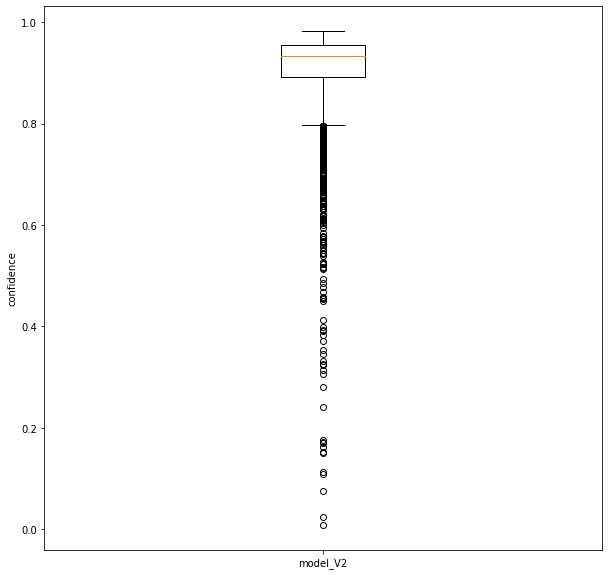

In [34]:
data = cnf
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_title('')
ax.boxplot(data)
ax.set_ylabel('confidence')
ax.set_xticklabels(['model_V2'])
# ax.set_ylim(0.9, 1.0)

plt.show()

(array([  2.,   0.,   0.,   1.,   0.,   2.,   0.,   3.,   3.,   0.,   0.,
          1.,   0.,   0.,   1.,   2.,   3.,   2.,   1.,   3.,   2.,   0.,
          3.,   2.,   3.,   1.,   6.,   5.,   6.,   4.,   5.,  12.,  11.,
         13.,  15.,  15.,  18.,  31.,  32.,  62.,  68.,  90., 126., 150.,
        231., 313., 503., 776., 956., 615.]),
 array([0.00813557, 0.02762298, 0.04711039, 0.0665978 , 0.0860852 ,
        0.10557261, 0.12506002, 0.14454743, 0.16403484, 0.18352225,
        0.20300966, 0.22249706, 0.24198447, 0.26147188, 0.28095929,
        0.3004467 , 0.31993411, 0.33942152, 0.35890892, 0.37839633,
        0.39788374, 0.41737115, 0.43685856, 0.45634597, 0.47583338,
        0.49532078, 0.51480819, 0.5342956 , 0.55378301, 0.57327042,
        0.59275783, 0.61224524, 0.63173265, 0.65122005, 0.67070746,
        0.69019487, 0.70968228, 0.72916969, 0.7486571 , 0.76814451,
        0.78763191, 0.80711932, 0.82660673, 0.84609414, 0.86558155,
        0.88506896, 0.90455637, 0.92404377, 0.

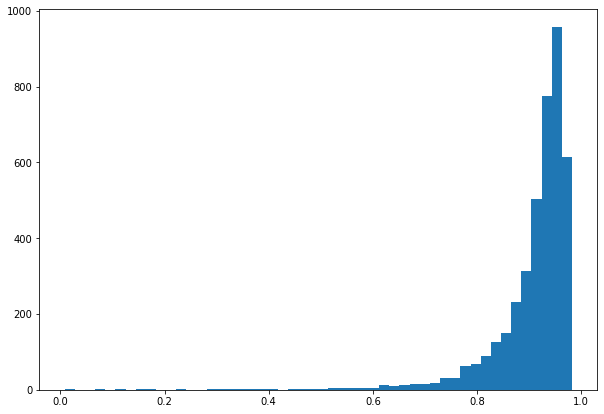

In [35]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 7)

ax.hist(cnf, bins=50)

## Find the 50 or so images with the lowest/highest cervix detection scores (Redrawn with white bb)

In [2]:
df_bb = pd.read_csv('/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/predictions/20230822_detector_predictions_v2/dysis_bb_V2.csv')

In [3]:
img_dir = '/mnt/2015P002510/rakin/cervical_cancer/cervix_classification/dysis_lesion_detector/predictions/20230822_detector_predictions_v2/extreme_images_bb_drawn/'
image_files = list(df_bb.sort_values(by=['det_conf'])[:50]['image'].values)
image_paths = [os.path.join(img_dir, image_file) for image_file in image_files]
images = [plt.imread(image_paths[i]) for i in range(len(image_paths))]

In [4]:
df_bb.sort_values(by=['det_conf'])[:50]['det_conf'].values

array([0.00813557, 0.0240935 , 0.0748626 , 0.108317  , 0.112345  ,
       0.150777  , 0.152466  , 0.162697  , 0.169511  , 0.17294   ,
       0.17649   , 0.240625  , 0.281274  , 0.305839  , 0.313523  ,
       0.32336   , 0.325639  , 0.332335  , 0.346159  , 0.353051  ,
       0.370983  , 0.383699  , 0.390895  , 0.39229   , 0.39902   ,
       0.412965  , 0.449757  , 0.454652  , 0.456017  , 0.457769  ,
       0.468669  , 0.477591  , 0.485713  , 0.492689  , 0.513764  ,
       0.515855  , 0.517523  , 0.522659  , 0.52308   , 0.525941  ,
       0.526645  , 0.539266  , 0.54358   , 0.54428   , 0.544719  ,
       0.551571  , 0.556052  , 0.560556  , 0.565255  , 0.565702  ])

In [5]:
image_files

['04462_img014.jpg',
 '04580_img070.jpg',
 '04580_img077.jpg',
 '04957_img042.jpg',
 '03102_img124.jpg',
 '04081_img014.jpg',
 '05392_img094.jpg',
 '03102_img114.jpg',
 '04742_img124.jpg',
 '03102_img070.jpg',
 '04462_img056.jpg',
 '03102_img042.jpg',
 '03102_img104.jpg',
 '03102_img084.jpg',
 '04462_img049.jpg',
 '03102_img049.jpg',
 '03102_img007.jpg',
 '03102_img063.jpg',
 '03102_img094.jpg',
 '03102_img014.jpg',
 '03102_img028.jpg',
 '03102_img077.jpg',
 '04742_img104.jpg',
 '03102_img035.jpg',
 '04354_img035.jpg',
 '03102_img056.jpg',
 '03102_img021.jpg',
 '04755_img042.jpg',
 '04783_img077.jpg',
 '04289_img124.jpg',
 '01236_img077.jpg',
 '01236_img084.jpg',
 '03662_img021.jpg',
 '05043_img070.jpg',
 '04742_img084.jpg',
 '00407_img000.jpg',
 '04742_img114.jpg',
 '04783_img114.jpg',
 '01236_img094.jpg',
 '05294_img035.jpg',
 '04783_img124.jpg',
 '01236_img104.jpg',
 '01236_img000.jpg',
 '00407_img021.jpg',
 '01236_img070.jpg',
 '00407_img007.jpg',
 '01236_img124.jpg',
 '04742_img09

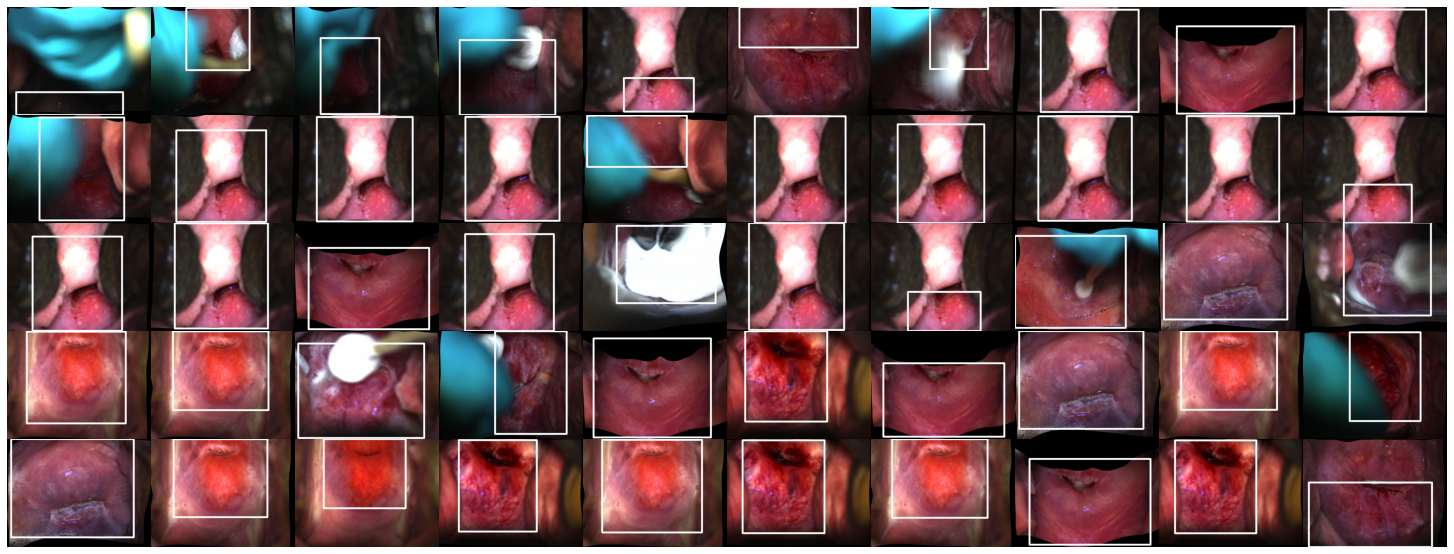

In [6]:
heights = [images[0].shape[0]]*5
widths = [images[0].shape[1]]*10

fig_width = 20.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(5,10, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

n = 0
for i in range(5):
    for j in range(10):
        axarr[i, j].imshow(images[n])
        axarr[i, j].axis('off')
        n += 1
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

In [7]:
# # matplotlib display
# fig = plt.subplots(5,10,figsize=(20,20))
# plt.subplots_adjust(wspace=0, hspace=0)
# for j in range(len(images)):
# # for j in range(images.shape[0]):
#     plt.subplot(5,10,j+1)
#     subfig = plt.imshow(images[j])
# #     subfig = plt.imshow(images[j,:,:,:])
#     subfig.axes.get_xaxis().set_visible(False)
#     subfig.axes.get_yaxis().set_visible(False)

In [8]:
image_files = list(df_bb.sort_values(by=['det_conf'])[-50:]['image'].values)
image_paths = [os.path.join(img_dir, image_file) for image_file in image_files]
images = [plt.imread(image_paths[i]) for i in range(len(image_paths))]

In [9]:
df_bb.sort_values(by=['det_conf'])[-50:]['det_conf'].values

array([0.97472 , 0.974771, 0.974883, 0.974921, 0.974935, 0.974958,
       0.974984, 0.975026, 0.975141, 0.975216, 0.975231, 0.975384,
       0.975477, 0.975502, 0.975515, 0.975544, 0.975583, 0.97563 ,
       0.975634, 0.975658, 0.975673, 0.975809, 0.975952, 0.976108,
       0.976138, 0.976163, 0.976199, 0.976393, 0.976448, 0.976478,
       0.97653 , 0.976636, 0.976659, 0.976782, 0.976832, 0.977055,
       0.977086, 0.977202, 0.977226, 0.977458, 0.977562, 0.977985,
       0.977994, 0.978255, 0.978836, 0.978873, 0.979762, 0.980311,
       0.9806  , 0.982506])

In [10]:
image_files

['02755_img035.jpg',
 '00063_img007.bmp',
 '01878_img014.jpg',
 '02755_img028.jpg',
 '04004_img056.jpg',
 '01994_img021.jpg',
 '02755_img014.jpg',
 '03977_img014.jpg',
 '03739_img124.jpg',
 '00068_img007.bmp',
 '03739_img014.jpg',
 '01878_img042.jpg',
 '04686_img000.jpg',
 '00053_img014.bmp',
 '00162_img077.bmp',
 '05039_img007.jpg',
 '03739_img114.jpg',
 '04623_img063.jpg',
 '04067_img014.jpg',
 '00068_img021.bmp',
 '03567_img000.jpg',
 '02406_img007.jpg',
 '01878_img007.jpg',
 '04703_img000.jpg',
 '04315_img028.jpg',
 '04755_img007.jpg',
 '03958_img014.jpg',
 '04951_img007.jpg',
 '03739_img021.jpg',
 '00129_img000.bmp',
 '05602_img007.jpg',
 '00068_img028.bmp',
 '04703_img007.jpg',
 '04067_img124.jpg',
 '04067_img114.jpg',
 '01878_img021.jpg',
 '03739_img084.jpg',
 '03557_img000.jpg',
 '05039_img000.jpg',
 '03739_img070.jpg',
 '03739_img063.jpg',
 '03739_img035.jpg',
 '03739_img077.jpg',
 '03739_img049.jpg',
 '03739_img056.jpg',
 '03739_img042.jpg',
 '04951_img000.jpg',
 '04067_img09

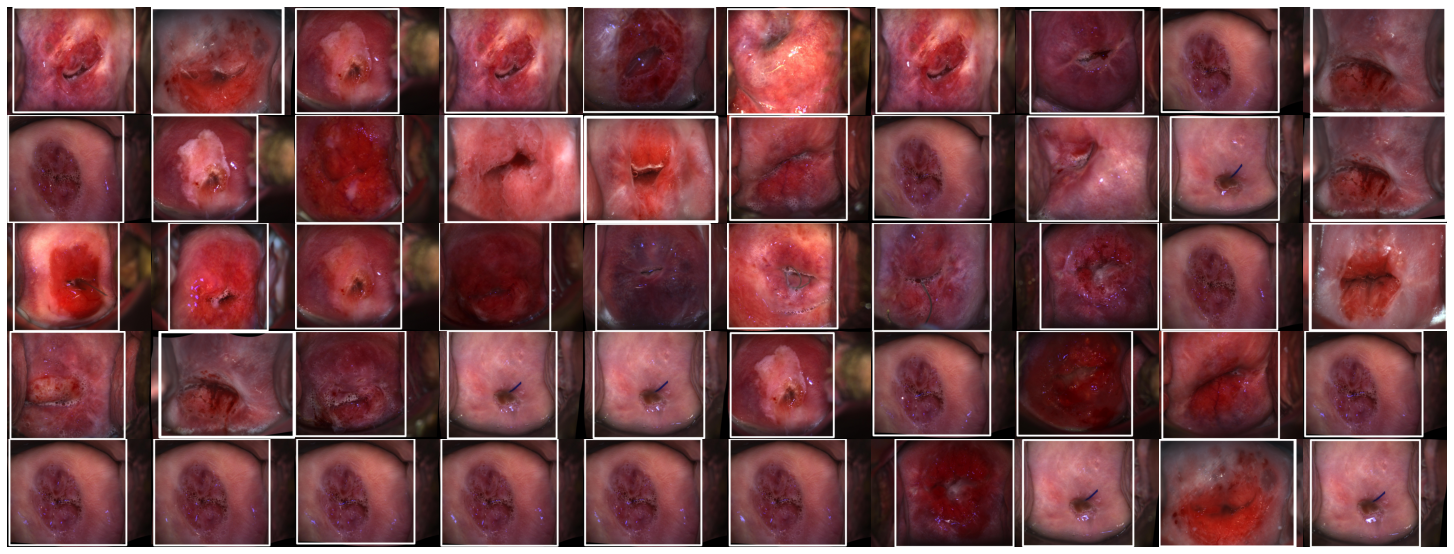

In [11]:
heights = [images[0].shape[0]]*5
widths = [images[0].shape[1]]*10

fig_width = 20.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(5,10, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

n = 0
for i in range(5):
    for j in range(10):
        axarr[i, j].imshow(images[n])
        axarr[i, j].axis('off')
        n += 1
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()